# Sales Rocket 🚀🚀🚀

Sales calls hold a wealth of untapped insights. Every transcript contains valuable signals about customer needs, objections, and pain points—but in most organizations, these records are left unused or are too cumbersome to analyze at scale. Traditional analytics tools struggle with this type of unstructured data, leaving sales teams without actionable guidance on how to improve their conversations or address recurring concerns.

This project tackles the problem by leveraging BigQuery’s advanced AI capabilities to transform raw sales call transcripts into structured insights. Using Generative AI (**ML.GENERATE_TEXT**) within BigQuery, it extracts recurring and new objections that directly impact purchasing decisions. Instead of letting transcripts collect dust, it creates a dynamic feedback loop that empowers sales teams to refine their messaging and close more deals.



#### Architecture Diagram

```text
      +----------------------------+        +------------------------------+
      |        Call transcripts    |        |          Google Cloud        |
      |        (text, CSV, JSON)   |        |    BigQuery & Vertex AI      |
      +-------------+--------------+        +---------------+--------------+
                    |  Load/ingest                          |
                    v                                       |
      +---------------------------+                         |
      | BigQuery: call_transcripts|                         |
      |           (table)         |                         |
      +-------------+-------------+                         |
                    |  Extract objections &                 |
                    |  assign categories using              v
                    |  ML.GENERATE_TEXT    +--------------------------------+   
                    |<---------------------| Vertex AI Connection           |
                    |                      | Gemini 2.5 Pro (generation)    |    
                    |                      +--------------------------------+              
                    v                                       
      +---------------------------+
      | BigQuery: objections      |
      |           (table)         |
      +-------------+-------------+
                    |
                    | Query / Dashboard / Export (e.g., BigQuery UI, BI)
                    v
      +---------------------------+
      |  Sales team / RevOps      |
      |  access insights          |
      +---------------------------+
```

## 1. Prerequisites

- **GCP Project** with BigQuery and Vertex AI services enabled
- **Model**: BigQuery [remote model](https://cloud.google.com/bigquery/docs/generate-text) powered by Vertex AI (*Gemini 2.5 Pro*)
- **Notebook Environment**: Google Colab or Kaggle (*with GCP integration*)  
- **PyPi Dependencies**:  
  - `datasets` — for loading the Hugging Face *saas-sales-conversations* dataset  
  - `google-cloud-bigquery` — for interacting with BigQuery  
  - `pandas` — for data manipulation  
  - `matplotlib` - for visiualization
- **Data**: Hugging Face [saas-sales-conversations](https://huggingface.co/datasets/DeepMostInnovations/saas-sales-conversations) datasets.


### 1.1 Installing Dependendencies

In [ ]:
!pip install pandas datasets google-cloud-bigquery matplotlib

### 1.2 GCP Project & BigQuery Settings


In [ ]:
# GCP Project ID
project_id = '<your-gcp-project-id>'

# BigQuery DataSet/Schema
dataset_id = '<exsing-bq-schema-in-above-project>'

# Call Transcripts Table Name
call_transcripts_table = 'call_transcripts'

# Objections Table
objections_table = 'objections'

# BigQuery Remote Model (format: project_id.dataset_id.model_name)
remote_model = '<your-remote-model>'

1.3 GCP Authentication for Google Colab

In [ ]:
# Obtain GCP auth token if the notebook is hosted by Colab
try:
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated using Google Colab')
except:
  print('Not authenticated using Google Colab')

Authenticated using Google Colab


## 2. Data

The Hugging Face [saas-sales-conversations](https://huggingface.co/datasets/DeepMostInnovations/saas-sales-conversations) dataset is a synthetic collection of sales conversations for SaaS companies, designed for training sales conversion prediction models.

For this project, we will use a subset of sales calls related to the *DataFlow Pro* product, filtered to include only conversations with more than 15 words.  

###

### 2.1 Download saas-sales-conversations Dataset

In [ ]:
from datasets import load_dataset

# Download saas-sales-conversations dataset
dataset = load_dataset("DeepMostInnovations/saas-sales-conversations", split="train")

# Convert dataset to pandas dataframe
all_conversations_df = dataset.to_pandas()

# Data preview
all_conversations_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cleaned_custom_dataset.csv:   0%|          | 0.00/7.17G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

,company_id,company_name,product_name,product_type,conversation_id,scenario,conversation,full_text,outcome,conversation_length,...,embedding_3062,embedding_3063,embedding_3064,embedding_3065,embedding_3066,embedding_3067,embedding_3068,embedding_3069,embedding_3070,embedding_3071
0,saas-7,AutoTest Pro,TestMaster Suite,Professional Services,saas-7-conv-0,"{""customer_persona"": {""name"": ""Jessica Martine...","[{""speaker"": ""customer"", ""message"": ""hey, quic...","hey, quick q... I've been hearing about automa...",1,10,...,0.017196,-0.003678,0.010616,0.018928,0.009148,-0.021489,0.004561,-0.006507,-0.005709,-0.021591
1,saas-7,AutoTest Pro,TestMaster Suite,Professional Services,saas-7-conv-20,"{""customer_persona"": {""name"": ""Sophia Martinez...","[{""speaker"": ""customer"", ""message"": ""Hey, I\u2...","Hey, I’ve been looking into some automation to...",0,13,...,0.007794,-0.007228,0.010654,0.017576,0.016625,-0.024679,0.001795,-0.005586,0.000598,-0.021084
2,saas-7,AutoTest Pro,TestMaster Suite,Professional Services,saas-7-conv-36,"{""customer_persona"": {""name"": ""Jessica Thompso...","[{""speaker"": ""customer"", ""message"": ""Hey, so I...","Hey, so I've been thinking abt that TestMaster...",0,10,...,0.010382,-0.007202,-0.003593,0.006435,0.025691,-0.020110,0.018535,-0.004169,0.011454,-0.017135
3,saas-7,AutoTest Pro,TestMaster Suite,Professional Services,saas-7-conv-51,"{""customer_persona"": {""name"": ""Michael Thompso...","[{""speaker"": ""customer"", ""message"": ""Hey! just...",Hey! just saw ur post about TestMaster Suite a...,1,14,...,0.015507,-0.011602,-0.008249,0.011681,0.007438,-0.013366,0.006714,0.006494,-0.000889,-0.019096
4,saas-7,AutoTest Pro,TestMaster Suite,Professional Services,saas-7-conv-67,"{""customer_persona"": {""name"": ""Jessica Hartman...","[{""speaker"": ""customer"", ""message"": ""Hey, I he...","Hey, I heard about TestMaster Suite. Can it re...",1,11,...,0.013529,-0.016722,0.007610,0.015744,0.013538,-0.014525,0.002788,-0.001443,0.003346,-0.020379


### 2.2 Extract Data Subset

In [ ]:
# Extract conversations for DataFlow Pro product
dataflow_pro_conversations_df = all_conversations_df[all_conversations_df['product_name'] == 'DataFlow Pro']

# Filter conversations that have over 15 words
dataflow_pro_conversations_df = dataflow_pro_conversations_df[dataflow_pro_conversations_df['conversation_length'] > 15]

# Extract "conversation_id", "scenario", "conversation" and "full_text" columns
dataflow_pro_conversations_df = dataflow_pro_conversations_df[['conversation_id', 'scenario', 'conversation', 'full_text']]

# Data preview
dataflow_pro_conversations_df.head()

,conversation_id,scenario,conversation,full_text
25140,saas-14-conv-89,"{""customer_persona"": {""name"": ""Laura Thompson""...","[{""speaker"": ""customer"", ""message"": ""Hey, so I...","Hey, so I’ve been hearin’ a lot about DataFlow..."
25367,saas-14-conv-358,"{""customer_persona"": {""name"": ""Laura Thompson""...","[{""speaker"": ""customer"", ""message"": ""Hey, so I...","Hey, so I was told to look into some, uh, ETL ..."
25428,saas-14-conv-462,"{""customer_persona"": {""name"": ""Alice Johnson"",...","[{""speaker"": ""customer"", ""message"": ""Hey, I at...","Hey, I attended the webinar on ETL solutions y..."
25486,saas-14-conv-472,"{""customer_persona"": {""name"": ""Maria Thompson""...","[{""speaker"": ""customer"", ""message"": ""Hey, so I...","Hey, so I guess we’re here to chat about DataF..."
25491,saas-14-conv-432,"{""customer_persona"": {""name"": ""Jordan Thompson...","[{""speaker"": ""customer"", ""message"": ""Hey, I've...","Hey, I've been looking into ETL solutions. We'..."


### 2.3 Uplaod the Conversations to BigQuery

In [ ]:
from google.cloud import bigquery

# Create or replace call BigQuery table
dataflow_pro_conversations_df.to_gbq(
    project_id=project_id,
    destination_table=f'{dataset_id}.{call_transcripts_table}',
    if_exists='replace')

/tmp/ipython-input-1974797512.py:4: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  dataflow_pro_conversations_df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 9986.44it/s]


## 3. Extract Objections Using BigQuery ML

In this step, we will use BigQuery's `ML.GENERATE_TEXT` functionality to automatically identify and extract sales objections from call transcripts. By leveraging generative AI within BigQuery, we can process unstructured text data and generate structured insights that highlight recurring concerns raised during sales conversations.  

### 3.1 Create objections Table

In [ ]:
# Query to create objections table
query = f'''
DECLARE prompt_template STRING;

SET prompt_template = """You are an expert conversational analyst specializing in business to business SaaS tool sales. Your task is to analyze the provided call transcript between a Sales Executive ("sales_rep") and a prospective customer ("Customer").

Your primary objective is to analyze the call transcript that is included below. Using the information in the call transcript only your goal is to return following information:

Specific Objections: This is information regarding any objections expressed by the customer during the call. Objections may be about DataFlow Pro product and its features, or even about a potential sales contract. Provide the following for each:
  - name: a short descriptor (2 words or less) summarizing the objection.
  - concern_summary: a detailed explanation of the objection in one sentence or less.
  - category: 1 for all pricing related objections, 2 for all secuirty related objections, 3 for all integration or implementation related objections, 4 for all ROI related objections, 5 for all scalability related objections, and 6 for all other objections.


Provide your selections as a JSON output without additional commentary. Return the response strictly in the JSON format as follows with nothing else and do not label it as JSON. If there is no applicable information for any category, still include that category with an empty list. Make sure all strings are contained in quotes:
'{{
  "objections": [
    {{"name": STRING,
     "summary": STRING,
     "category": INTEGER
    }}
  ]
}}'

**Normal Output Example:**
'{{
  "objections": [
    {{"name": "Pricing"
     "summary": "The customer's voiced the objection X number of times.",
     "category": 1
    }},
    {{"name": "Integration"
     "summary": "The customer uses XYZ products and concerned about the integration process.",
     "category": 3
    }}
  ]
}}'

**Empty Output Example:**
'{{
  "objections": [
  ]
}}'

Call Transcript:

""";


-- Create objections table
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.{objections_table}`
AS

WITH transcripts AS (
  SELECT
    conversation_id,
    prompt_template || conversation as prompt
  FROM `{project_id}.{dataset_id}.{call_transcripts_table}`
),

objections_nested AS (
  SELECT
    conversation_id,
    TRIM(REGEXP_REPLACE(ml_generate_text_llm_result, "(```|json)", "")) AS generated_text
  FROM ML.GENERATE_TEXT(MODEL `{ remote_model }`,
                        TABLE transcripts,
                        STRUCT(0.2 AS temperature,
                              8000 AS max_output_tokens,
                              TRUE AS flatten_json_output))
),

objections AS (
  SELECT
    conversation_id,
    JSON_VALUE(objection, '$.name') AS objection_name,
    JSON_VALUE(objection, '$.summary') AS objection_summary,
    CAST(JSON_VALUE(objection, '$.category') AS INT64) AS objection_category
  FROM objections_nested
    INNER JOIN UNNEST(JSON_EXTRACT_ARRAY(generated_text, '$.objections')) AS objection
)

SELECT *
FROM objections;
'''

# print(query)

In [ ]:
from google.cloud import bigquery
# Create objections table
client = bigquery.Client(project=project_id)
query_job = client.query(query)
query_job.result()
print('Objections table is created successfully')

Objections table is created successfully


## 4. Download objections Table as a DataFame

In [ ]:
# Download objections Table as a DataFame
objections_df = client.query(f'SELECT * FROM `{project_id}.{dataset_id}.{objections_table}`').to_dataframe()

# Assign category names
category_mapping = {
    1: 'Pricing',
    2: 'Security',
    3: 'Integration',
    4: 'ROI',
    5: 'Scalibility',
    6: 'Other'
}
objections_df['objection_category'] = objections_df['objection_category'].map(category_mapping)

# Data preview
objections_df.head()

,conversation_id,objection_name,objection_summary,objection_category
0,saas-14-conv-2051,Perceived Risk,The customer feels there is a lot of risk invo...,ROI
1,saas-14-conv-2116,Upfront Cost,The customer is worried about the upfront inve...,Pricing
2,saas-14-conv-1386,High Price,The customer expressed that the initial invest...,Pricing
3,saas-14-conv-877,Implementation Complexity,The customer is concerned about the complexity...,Integration
4,saas-14-conv-1952,Pricing,The customer stated that the monthly subscript...,Pricing


## 5. Visualize and Analyze

### 5.1 Visualize the Results

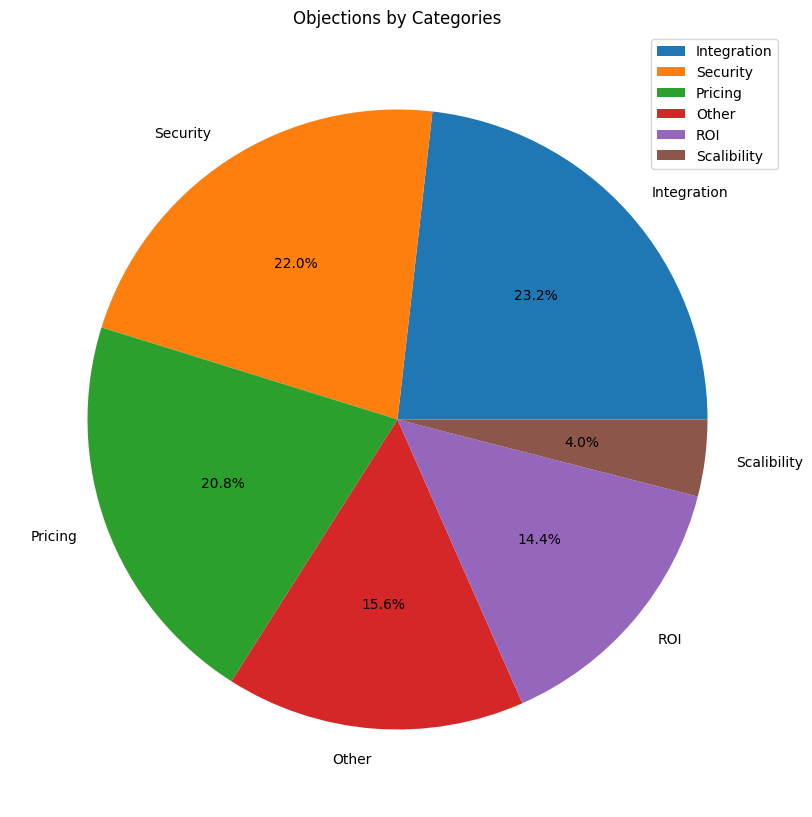

In [ ]:
import matplotlib.pyplot as plt

# Draw objections PIE chart using category field
fig, ax = plt.subplots(figsize=(10, 14))
ax.pie(objections_df['objection_category'].value_counts(), labels=objections_df['objection_category'].value_counts().index, autopct='%1.1f%%')
ax.set_title('Objections by Categories')
ax.legend(loc='upper right')
plt.show()

### 5.2 Dive Deeper into Objections in the "Other" Category

In addition to the main categories of objections, we can analyze the transcripts labeled as **"Other"** to uncover less common but potentially critical concerns. By understanding these overlooked objections, sales teams can prepare targeted response scripts and ensure they are equipped to handle a wider range of scenarios during future conversations.  

In [ ]:
# Filter objections in "Other" category
objections_df[objections_df['objection_category'] == 'Other'].sort_values(by='objection_name')

,conversation_id,objection_name,objection_summary,objection_category
222,saas-14-conv-1952,Adoption Risk,The customer was concerned about what happens ...,Other
132,saas-14-conv-2637,Bad Timing,The customer stated they do not want to add mo...,Other
216,saas-14-conv-462,Claim Skepticism,The customer is skeptical about the product's ...,Other
11,saas-14-conv-701,Commitment Risk,The customer is concerned about the risk of co...,Other
49,saas-14-conv-3478,Contract Length,The customer is worried about being committed ...,Other
137,saas-14-conv-1245,Data Accuracy,The customer questioned how the platform ensur...,Other
38,saas-14-conv-2730,Data Accuracy,The customer is concerned about the accuracy o...,Other
87,saas-14-conv-1952,Data Quality,The customer expressed concern about the trust...,Other
92,saas-14-conv-739,Decision Hesitation,The customer stated the decision was a big one...,Other
14,saas-14-conv-3721,Decision Risk,The customer expressed hesitation due to the o...,Other
